In [17]:
import json
import math
import random
import torch

import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from torch.optim.lr_scheduler import StepLR
from torch.optim import Adam
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [18]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [19]:
def process_data(file_path):
    with open(file_path, "r") as file:
        datas = json.load(file)

    dataset = []
    for data in datas:
        user_info = []
        for key, value in data["user_info"].items():
            if value:
                user_info.append(f"{key}_{value}")
        
        parameter = []
        for key, value in data["parameter"].items():
            parameter.append(value)
        dataset.append({"user_info": user_info, "parameter": parameter})

    return dataset

In [20]:
data_path = "../../train_data/type_1/data.json"
dataset = process_data(data_path)
dataset[0]

{'user_info': ['age_81',
  'r_htl_8000_80',
  'r_htl_6000_70',
  'r_htl_4000_60',
  'r_htl_1000_70',
  'r_htl_2000_60',
  'r_htl_500_70',
  'l_htl_8000_85',
  'l_htl_4000_85',
  'l_htl_1000_100',
  'l_htl_2000_85',
  'l_htl_500_70'],
 'parameter': [2,
  47,
  28,
  28,
  28,
  28,
  28,
  28,
  48,
  38,
  39,
  35,
  31,
  30,
  28,
  28,
  28,
  60,
  43,
  43,
  43,
  43,
  43,
  43,
  61,
  51,
  52,
  48,
  44,
  45,
  43,
  43,
  43,
  32,
  32,
  32,
  32,
  32,
  32,
  32,
  32,
  32,
  32,
  32,
  32,
  32,
  32,
  32,
  32,
  15,
  0,
  47,
  28,
  28,
  28,
  28,
  28,
  28,
  48,
  38,
  35,
  30,
  28,
  28,
  28,
  60,
  41,
  41,
  41,
  41,
  41,
  41,
  61,
  51,
  52,
  48,
  44,
  43,
  41,
  41,
  41,
  15,
  0,
  47,
  28,
  28,
  28,
  28,
  28,
  28,
  48,
  38,
  35,
  30,
  28,
  28,
  28,
  60,
  41,
  41,
  41,
  41,
  41,
  41,
  61,
  51,
  52,
  48,
  44,
  43,
  41,
  41,
  41,
  60,
  70,
  7,
  10,
  3,
  5]}

In [21]:
# special symbols
special_symbols = ['<pad>',]

# make vocab
user_info_vocab = list(special_symbols)

for data in dataset:
    user_info_vocab.extend(data["user_info"])

user_info_vocab = sorted(list(set(user_info_vocab)))

len(user_info_vocab)

1214

In [22]:
for index, word in enumerate(user_info_vocab):
    if index < 200:
        print(f"Word: {word} —— Index: {index}")
    else:
        break

Word: <pad> —— Index: 0
Word: age_1 —— Index: 1
Word: age_10 —— Index: 2
Word: age_104 —— Index: 3
Word: age_1048 —— Index: 4
Word: age_11 —— Index: 5
Word: age_12 —— Index: 6
Word: age_13 —— Index: 7
Word: age_14 —— Index: 8
Word: age_15 —— Index: 9
Word: age_16 —— Index: 10
Word: age_17 —— Index: 11
Word: age_18 —— Index: 12
Word: age_19 —— Index: 13
Word: age_2 —— Index: 14
Word: age_20 —— Index: 15
Word: age_21 —— Index: 16
Word: age_22 —— Index: 17
Word: age_23 —— Index: 18
Word: age_24 —— Index: 19
Word: age_25 —— Index: 20
Word: age_26 —— Index: 21
Word: age_27 —— Index: 22
Word: age_28 —— Index: 23
Word: age_29 —— Index: 24
Word: age_3 —— Index: 25
Word: age_30 —— Index: 26
Word: age_31 —— Index: 27
Word: age_32 —— Index: 28
Word: age_33 —— Index: 29
Word: age_34 —— Index: 30
Word: age_35 —— Index: 31
Word: age_36 —— Index: 32
Word: age_37 —— Index: 33
Word: age_38 —— Index: 34
Word: age_39 —— Index: 35
Word: age_4 —— Index: 36
Word: age_40 —— Index: 37
Word: age_41 —— Index: 3

In [23]:
train_path = "../../train_data/type_1/train.json"
valid_path = "../../train_data/type_1/valid.json"

train_dataset = process_data(train_path)
valid_dataset = process_data(valid_path)

In [24]:
# Tokenize (only input data)
token_train_dataset = []
for data in train_dataset:
    user_info = [user_info_vocab.index(word) for word in data["user_info"]]
    token_train_dataset.append({"user_info": user_info, "parameter": data["parameter"]})


token_valid_dataset = []
for data in valid_dataset:
    user_info = [user_info_vocab.index(word) for word in data["user_info"]]
    token_valid_dataset.append({"user_info": user_info, "parameter": data["parameter"]})

In [25]:
for data in token_train_dataset:
    print(data["user_info"])
    print(data["parameter"])
    break

[30, 1096, 1003, 886, 930, 953, 1026, 445, 330, 373, 401, 471]
[11, 39, 38, 38, 38, 38, 38, 38, 41, 39, 39, 42, 43, 42, 38, 38, 38, 57, 56, 56, 56, 56, 56, 56, 58, 58, 57, 59, 60, 60, 56, 56, 56, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 15, 8, 40, 37, 37, 37, 37, 37, 37, 38, 40, 33, 33, 37, 37, 37, 54, 51, 51, 51, 51, 51, 51, 52, 54, 52, 47, 58, 47, 51, 51, 51, 15, 4, 40, 37, 37, 37, 37, 37, 37, 38, 40, 33, 33, 37, 37, 37, 54, 51, 51, 51, 51, 51, 51, 52, 54, 52, 47, 58, 47, 51, 51, 51, 60, 70, 7, 10, 3, 5]


In [26]:
class HearingAidDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.scaler = MinMaxScaler()
        
        # 提前将参数归一化
        params = [item["parameter"] for item in dataset]
        self.scaled_params = self.scaler.fit_transform(params)

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        user_info = self.dataset[idx]["user_info"]
        user_info_tensor = torch.tensor(user_info, dtype=torch.long)
        param_tensor = torch.tensor(self.scaled_params[idx], dtype=torch.float32)
        
        return user_info_tensor, param_tensor

In [27]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=300, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) # Shape (1, max_len, d_model)
        self.register_buffer('pe', pe)


    def forward(self, x):
        """
            x: (batch_size, x_len, d_model)
            requires_grad_(False) is used to prevent the model from updating the positional encoding
        """
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

In [28]:
class TransformerMultiOutputRegressor(nn.Module):
    def __init__(self, src_vocab_size, n_outputs, d_model, n_heads, n_layers, dropout=0.1, batch_first=True):
        super().__init__()
        self.src_tok_emb = nn.Embedding(src_vocab_size, d_model)
        self.transformer = nn.Transformer(
            d_model=d_model, 
            nhead=n_heads, 
            num_encoder_layers=n_layers, 
            num_decoder_layers=n_layers,
            dropout=dropout, 
            batch_first=batch_first
        )
        self.positional_encoding = PositionalEncoding(d_model=d_model, dropout=dropout)
        self.regressor = nn.Linear(d_model, n_outputs)


    def forward(self, src):
        src_key_padding_mask = (src == 2)

        src = self.src_tok_emb(src)
        src = self.positional_encoding(src)

        memory = self.transformer.encoder(
            src,
            src_key_padding_mask=src_key_padding_mask
        )

        output = self.regressor(memory[:, -1, :])
        return output

In [29]:
len(token_train_dataset[0]["parameter"])

119

In [30]:
# 初始化模型
src_vocab_size = len(user_info_vocab)
n_outputs = len(token_train_dataset[0]["parameter"])
d_model = 128
n_heads = 8
n_layers = 6
dropout = 0.1
batch_first = True

model = TransformerMultiOutputRegressor(src_vocab_size, n_outputs, d_model, n_heads, n_layers, dropout, batch_first).to(DEVICE)
model

TransformerMultiOutputRegressor(
  (src_tok_emb): Embedding(1214, 128)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x Transforme

In [31]:
# 超参数
batch_size = 64
learning_rate = 0.0001

In [32]:
def collate_fn(batch):
    user_info, param = zip(*batch)
    user_info = nn.utils.rnn.pad_sequence(user_info, batch_first=True, padding_value=user_info_vocab.index('<pad>'))

    param = torch.stack(param)
    return user_info, param

In [33]:
training_dataset = HearingAidDataset(token_train_dataset)
valid_dataset = HearingAidDataset(token_valid_dataset)

training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=4, pin_memory=True)

In [34]:
# 测试模型输出
for user_info, param in training_loader:
    user_info = user_info.to(DEVICE)
    param = param.to(DEVICE)
    print(user_info)
    print(param.shape)
    output = model(user_info)
    print(output.shape)
    break

tensor([[  78,    0,    0,  ...,    0,    0,    0],
        [  72, 1091,  995,  ...,    0,    0,    0],
        [  68, 1096, 1000,  ...,    0,    0,    0],
        ...,
        [  55, 1074,  979,  ...,    0,    0,    0],
        [  66, 1089,  995,  ...,    0,    0,    0],
        [  61, 1092, 1000,  ...,    0,    0,    0]], device='cuda:0')
torch.Size([64, 119])
torch.Size([64, 119])


In [35]:
# Model, loss function, optimizer
criterion = nn.L1Loss()
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1) 

# Early stopping parameters
early_stopping_patience = 10
best_val_loss = float('inf')
patience_counter = 0

train_losses = []
valid_losses = []

# Example training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for user_info, param in training_loader:
        user_info = user_info.to(DEVICE)
        param = param.to(DEVICE)

        optimizer.zero_grad()
        output = model(user_info)
        loss = criterion(output, param)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(training_loader)
    train_losses.append(avg_train_loss)
    
    # Validation step
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for user_info, param in valid_loader:
            user_info = user_info.to(DEVICE)
            param = param.to(DEVICE)
            output = model(user_info)
            val_loss = criterion(output, param)
            total_val_loss += val_loss.item()
    
    avg_val_loss = total_val_loss / len(valid_loader)
    valid_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.3f}, Validation Loss: {avg_val_loss:.3f}")
    
    # Check for early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), '../models/best_model_type_2.pth')  # Save the best model
    else:
        patience_counter += 1
    
    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered")
        break
    
    scheduler.step()  # Update learning rate

print("Training complete. Best Validation Loss: {:.3f}".format(best_val_loss))

Epoch 1, Training Loss: 0.208, Validation Loss: 0.138
Epoch 2, Training Loss: 0.147, Validation Loss: 0.139
Epoch 3, Training Loss: 0.139, Validation Loss: 0.138
Epoch 4, Training Loss: 0.134, Validation Loss: 0.138
Epoch 5, Training Loss: 0.132, Validation Loss: 0.139
Epoch 6, Training Loss: 0.130, Validation Loss: 0.138
Epoch 7, Training Loss: 0.129, Validation Loss: 0.138
Epoch 8, Training Loss: 0.127, Validation Loss: 0.139
Epoch 9, Training Loss: 0.127, Validation Loss: 0.137
Epoch 10, Training Loss: 0.126, Validation Loss: 0.137
Epoch 11, Training Loss: 0.125, Validation Loss: 0.137
Epoch 12, Training Loss: 0.125, Validation Loss: 0.137
Epoch 13, Training Loss: 0.125, Validation Loss: 0.137
Epoch 14, Training Loss: 0.125, Validation Loss: 0.137
Epoch 15, Training Loss: 0.125, Validation Loss: 0.137
Epoch 16, Training Loss: 0.125, Validation Loss: 0.137
Epoch 17, Training Loss: 0.125, Validation Loss: 0.137
Epoch 18, Training Loss: 0.125, Validation Loss: 0.137
Epoch 19, Training 

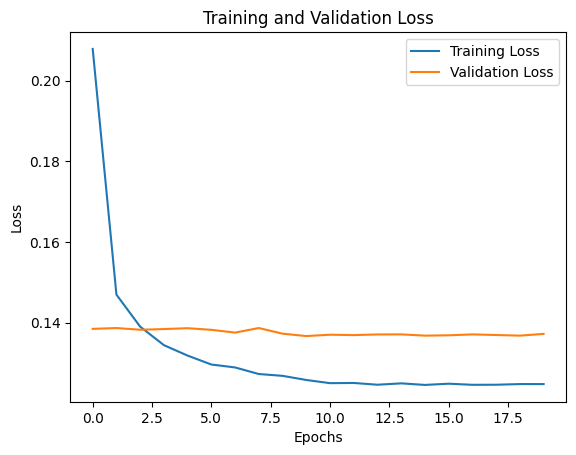

In [36]:
# Plot the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
model.load_state_dict(torch.load('../models/best_model_type_1.pth'))
model.eval()

TransformerMultiOutputRegressor(
  (src_tok_emb): Embedding(1214, 128)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x Transforme

In [38]:
def predict(sample):
    # Tokenize the sample
    user_info = [user_info_vocab.index(word) for word in sample["user_info"]]
    real = sample["parameter"]
    scaler = MinMaxScaler()
    real_normalized = scaler.fit_transform([real])

    # Convert to tensor
    user_info_tensor = torch.tensor(user_info, dtype=torch.long).unsqueeze(0).to(DEVICE)

    user_info_tensor

    # Make a prediction
    model.eval()
    with torch.no_grad():
        pred = model(user_info_tensor)
        pred = scaler.inverse_transform(pred.cpu().numpy())[0]
        # pred = [int(i) for i in pred]
   
    return real, pred

In [39]:
pd.set_option('display.max_rows', None)

# randomly select a sample from the test set
test_path = "../../train_data/type_1/test.json"
test_dataset = process_data(test_path)

sample = random.choice(test_dataset)
real, pred = predict(sample)

# calculate the accuracy
correct = 0
for a, b in zip(real, pred):
    if  abs(a - b) <= 0:
        correct += 1
print(f"Accuracy: {correct / len(real) * 100:.2f}%")


results = pd.DataFrame({
    '真实值': real,
    '预测值': pred,
})

results

Accuracy: 0.00%


,真实值,预测值
0,0,0.156035
1,33,33.432240
2,21,21.347393
3,21,21.347170
4,21,21.348337
5,21,21.348183
6,21,21.350311
7,21,21.349110
8,36,36.473633
9,36,36.493484


In [40]:
# # 计算误差
# pred = np.array(pred)
# real = np.array(real)
# errors = pred - real

# # 绘制误差的箱型图
# plt.boxplot(errors)
# plt.title("Prediction Errors Boxplot")
# plt.xlabel("Error")
# plt.show()

In [41]:
accuracy = []
for item in test_dataset:
    if item["user_info"]:
        reals, preds = predict(item)
        correct = 0
        for real, pred in zip(reals, preds):
            if abs(real - pred) <= 1:
                correct += 1
        accuracy.append(correct / len(reals))

print(f"Average Accuracy: {sum(accuracy) / len(accuracy) * 100:.2f}%")

Average Accuracy: 100.00%
